In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, json
import pandas as pd
import numpy as np

mpl.rcParams.update({'font.size': 22, 'lines.linewidth': 3, 'lines.markersize': 15, 'font.family': 'Times New Roman'})
    # avoid type 3 (i.e. bitmap) fonts in figures
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True


def get_ranking_type_dist(alldicts):
    types = np.zeros(8)
    for d in alldicts:
        #print(d)
        types[d["ranking"][0]["itemID"]] = types[d["ranking"][0]["itemID"]] + 1
    print(types)

def get_ranking_action_pairs(alldicts):
    types = np.zeros(8)
    events = []
    for d in alldicts:
        #print(d)
        rankingType = d["ranking"][0]["itemID"]
        rankings = []
        for rep in d["ranking"]:
            if rep["category"] == "rankingRepresentation":
                rankings.append(rep["ranking"])
        rankingIndex = 0
        for i in range(0,len(d["ranking"])):
            if d["ranking"][i]["category"] == "rankingRepresentation":
                i+=1
                actions = []
                while d["ranking"][i]["category"] != "rankingRepresentation" and d["ranking"][i]["category"] != "timeStamps":
                    actions.append(d["ranking"][i])
                    i+=1
                event_dic = {}
                event_dic["ranking"] = rankings[rankingIndex]
                event_dic["actions"] = actions
                event_dic["rankingType"] = rankingType
                events.append(event_dic)
                rankingIndex+=1
        rankingIndex=0
    return events
    
def get_ranking_action_pairs_by_ranking_type(alldicts, ranking_types):
    types = np.zeros(8)
    events = []
    for d in alldicts:
        #print(d)
        rankingType = d["ranking"][0]["itemID"]
        if rankingType not in ranking_types:
            continue
        rankings = []
        for rep in d["ranking"]:
            if rep["category"] == "rankingRepresentation":
                rankings.append(rep["ranking"])
        rankingIndex = 0
        task = 0
        for i in range(0,len(d["ranking"])):
            if d["ranking"][i]["category"] == "rankingRepresentation":
                task +=1
                if task == 4:
                    task = 1
                i+=1
                actions = []
                while d["ranking"][i]["category"] != "rankingRepresentation" and d["ranking"][i]["category"] != "timeStamps":
                    actions.append(d["ranking"][i])
                    i+=1
                event_dic = {}
                event_dic["ranking"] = rankings[rankingIndex]
                event_dic["actions"] = actions
                event_dic["rankingType"] = rankingType
                event_dic["task"] = task 
                events.append(event_dic)
                rankingIndex+=1
        rankingIndex=0
    return events

def get_average_object_by_gender(events):
    average_male = {}
    average_female = {}
    sum_xp_male = 0
    males_seen = 0
    females_seen = 0
    male_sum_rank = 0
    female_sum_rank = 0
    for event in events:
        for cand in event["ranking"]:
            if(cand["gender"] == "m"):
                males_seen +=1
                male_sum_rank += cand["rank"]
                sum_xp_male += cand["totalExp"]
            if(cand["gender"] == "f"):
                females_seen +=1
                female_sum_rank += cand["rank"]

def get_chosen_rank_distribution(events):
    ranks_chosen = np.zeros(20)
    for event in events:
        for action in event["actions"]:
            if action["eventName"] == "select":
                id = action["itemID"]
                if isinstance(event["ranking"][0],list):
                    event["ranking"] = [y for x in event["ranking"] for y in x]
                for cand in event["ranking"]:
                    if cand["id"] == id:
                        ranks_chosen[cand["rank"]-1] +=1
            if action["eventName"] == "unselect":
                id = action["itemID"]
                for cand in event["ranking"]:
                    if cand["id"] == id:
                        ranks_chosen[cand["rank"]-1] -=1
    return ranks_chosen

def get_gender_chosen_rank_distribution(events, gender):
    ranks_chosen = np.zeros(20)
    for event in events:
        for action in event["actions"]:
            if action["eventName"] == "select":
                id = action["itemID"]
                for cand in event["ranking"]:
                    if cand["id"] == id and cand["gender"] == gender:
                        ranks_chosen[cand["rank"]-1] +=1
            if action["eventName"] == "unselect":
                id = action["itemID"]
                for cand in event["ranking"]:
                    if cand["id"] == id and cand["gender"] == gender:
                        ranks_chosen[cand["rank"]-1] -=1
            if action["eventName"] == "fourthElementSelected":
                id = action["itemID"]
                for cand in event["ranking"]:
                    if cand["id"] == id and cand["gender"] == gender:
                        ranks_chosen[cand["rank"]-1] -=1
    return ranks_chosen

def get_choices_of_respondent(d):
    experiments = []
    representations = []
    for item in d["ranking"]:
        if item["category"] == "rankingRepresentation":
            if d["ranking"][0]["itemID"] > 3:
                item["ranking"] = [y for x in item["ranking"] for y in x]
            representations.append(item["ranking"])
    for i in range(0,len(d["ranking"])):
        if d["ranking"][i]["category"] == "rankingRepresentation":
                i+=1
                choices = []
                while d["ranking"][i]["category"] != "rankingRepresentation" and d["ranking"][i]["category"] != "timeStamps":
                    if d["ranking"][i]["eventName"] == "select":
                        choices.append(d["ranking"][i]["itemID"])
                    if d["ranking"][i]["eventName"] == "unselect":
                        choices.remove(d["ranking"][i]["itemID"])
                    if d["ranking"][i]["eventName"] == "fourthElementSelected":
                        choices.remove(d["ranking"][i]["itemID"])
                    i+=1
                experiments.append(choices)
    candidates_per_experiment = []
    for i in range(0,len(experiments)):
        choice_of_experiment = []
        for id in experiments[i]:
            for candidate in representations[i]:
                if id == candidate["id"]:
                    choice_of_experiment.append(candidate)
        candidates_per_experiment.append(choice_of_experiment)
    return candidates_per_experiment

def get_number_of_male_and_female_candidates_of_experiement(choices):
    experiment = [None] * 3
    exp_counter = 0
    for choice in choices:
        males = 0
        females = 0
        for candidate in choice:
            if candidate["gender"] == "m":
                males +=1
            if candidate["gender"] == "f":
                females +=1
        experiment[exp_counter] = [males,females]
        exp_counter +=1
    return experiment

def get_list_of_text_field_answers(alldicts):
    ranking_description = ['female_dom_not_sorted', 'male_dom_not_sorted', 'female_dom_sorted', 'male_dom_sorted', 
                       'two_list_sorted_women_left_female_dom', 'two_list_sorted_women_left_male_dom', 
                       'two_list_sorted_women_right_female_dom', 'two_list_sorted_women_right_male_dom']
    text_answers = []
    for item in alldicts:
        rankingType = item["ranking"][0]["itemID"]
        choices = get_number_of_male_and_female_candidates_of_experiement(get_choices_of_respondent(item))
        for answer in item["survey"]:
            #print(answer)
            if 'question' in answer and answer["question"] == 3:
                #print(answer)
                choice_str = []
                for choice in choices:
                    choice_str.append("m:"+str(choice[0]) +", f:"+str(choice[1]))
                text_answers.append(ranking_description[rankingType]+"\n"+answer["answers"][0] + "\n"+str(choice_str))
    return text_answers

def create_xp_rank_gender_ranking_type_plot_data(alldicts, ranking_types = [0,1,2,3,4,5,6,7]):
    pairs = get_ranking_action_pairs_by_ranking_type(alldicts,ranking_types)

    xp_gender_rank_tuples = []
    for cand in pairs:
        selected = []
        for pair in cand["actions"]:
            if pair["eventName"] == "select":
                selected.append(pair["itemID"])
            if pair["eventName"] == "unselect":
                selected.remove(pair["itemID"])
            if pair["eventName"] == "fourthElementSelected":
                selected.remove(pair["itemID"])
            if cand["rankingType"] > 3:
                flat_list = [y for x in cand["ranking"] for y in x]
            else:
                flat_list = cand["ranking"]
        for cand_id in selected:
            for rank in flat_list:
                for i in range(0,len(rank)):
                    if cand_id == rank["id"]:
                        total_xp = rank["totalExp"]
                        furniture_xp = rank["tag1"]
                        home_xp = rank["tag2"]
                        gender = rank["gender"]
                        rank_num = rank["rank"]
                        rankingType = cand["rankingType"]
                        task = cand["task"]
                        xp_gender_rank_tuples.append([total_xp,gender,rank_num,rankingType,furniture_xp,home_xp, task])
                        break
    return xp_gender_rank_tuples

def gender_xp_tuples_for_tasks(tuples, tasks = [1,2,3]):
    female_furniture_xp = []
    female_home_xp = []
    female_rank = []
    male_furniture_xp = []
    male_home_xp = []
    male_rank = []
    for arr in tuples:
        if arr[6] in tasks:
            if arr[1] == "f":
                female_furniture_xp.append(arr[4])
                female_home_xp.append(arr[5])
                female_rank.append(arr[2])
            if arr[1] == "m":
                male_furniture_xp.append(arr[4])
                male_home_xp.append(arr[5])
                male_rank.append(arr[2])
    return female_furniture_xp, female_home_xp, female_rank, male_furniture_xp, male_home_xp, male_rank
    
def split_xp_rank_gender_tuples_in_4_lists(tuples):
    female_total_experience = []
    female_ranks = []
    male_total_experience = []
    male_ranks = []
    for arr in tuples:
        if arr[1] == "f":
            female_total_experience.append(arr[0])
            female_ranks.append(arr[2])
        if arr[1] == "m":
            male_total_experience.append(arr[0])
            male_ranks.append(arr[2])
    return female_total_experience, female_ranks, male_total_experience, male_ranks

def get_task_ranking(dict, ranking_type, task):
    representations_seen = 0
    index = 0
    for i in range(0,len(dict["ranking"])):
        if dict["ranking"][i]["category"] == "rankingRepresentation":
            representations_seen +=1
            if task == representations_seen:
                index = i
                break
    if ranking_type <= 3:
        ranking = dict["ranking"][index]["ranking"]
    if ranking_type >3:
        ranking = []
        for tuple in dict["ranking"][index]["ranking"]:
            ranking.append(tuple[0])
            ranking.append(tuple[1])
    return ranking

def get_task_actions(dict, task):
    representations_seen = 0
    start_index = 0
    found_start = False
    end_index = 0
    for i in range(0,len(dict["ranking"])):
        if dict["ranking"][i]["category"] == "rankingRepresentation":
            representations_seen +=1
            if task == representations_seen and not found_start:
                start_index = i + 1
                found_start = True
                if task == 3:
                    end_index = len(dict["ranking"])-2
                    break
            if task + 1 == representations_seen and found_start:
                end_index = i
                break
    actions = []
    for i in range(start_index, end_index):
        actions.append(dict["ranking"][i])
    return actions

def get_task_choices(dict, ranking_type, task):
    actions = get_task_actions(dict, task)
    ranking = get_task_ranking(dict, ranking_type, task)
    selected_ids = []
    for action in actions:
        if action["eventName"] == "select":
            selected_ids.append(action["itemID"])
        if action["eventName"] == "unselect":
            selected_ids.remove(action["itemID"])
        if action["eventName"] == "fourthElementSelected":
            selected_ids.remove(action["itemID"])
    choices = []
    for id in selected_ids:
        for cand in ranking:
            if id == cand["id"]:
                choices.append(cand)
    return choices

def get_survey_answers(dict):
    survey = dict["survey"]
    answers = []
    for entry in survey:
        if entry["category"] == "surveyQuestionAnswers":
            answers.append(entry)
    return answers

def get_briefing_duration(dict):
    start = dict["briefing"][0]["timeOfEvent"]
    end = dict["briefing"][len(dict["briefing"])-1]["timeOfEvent"]
    return end-start

def get_task_time(dict, task):
    representations_seen = 0
    start_time = 0
    found_start = False
    end_time = 0
    for i in range(0,len(dict["ranking"])):
        if dict["ranking"][i]["category"] == "loadNewRankingType":
            representations_seen +=1
            if task == representations_seen and not found_start:
                start_time = dict["ranking"][i]["timeOfEvent"]
                found_start = True
                if task == 3:
                    end_time = dict["ranking"][len(dict["ranking"])-1]["timeOfEvent"]
                    break
            if task + 1 == representations_seen and found_start:
                end_time = dict["ranking"][i]["timeOfEvent"]
                break
    return end_time - start_time

def get_survey_duration(dict):
    start_survey = dict["survey"][0]["timeOfEvent"]
    end_survey = dict["survey"][len(dict["survey"])-3]["timeOfEvent"]
    return end_survey-start_survey

cols = ['uID', 'ranking_type','briefing','task_1_ranking', 'task_2_ranking', 'task_3_ranking',
           'task_1_actions','task_2_actions','task_3_actions','choices_task_1','choices_task_2','choices_task_3','survey_answers',
           'time_briefing','time_task_1','time_task_2','time_task_3','time_survey']
path_to_jsonfiles = "./jsonFiles_valid_third_test"
alldicts = []
for file in os.listdir(path_to_jsonfiles):
    full_filename = "%s/%s" % (path_to_jsonfiles, file)
    with open(full_filename,'r') as fi:
        dict = json.load(fi)
        alldicts.append(dict)
        
#print((alldicts[0])["ranking"])
get_ranking_type_dist(alldicts)
#create_xp_rank_gender_ranking_type_plot_data(alldicts, ranking_types=[4,5,6,7])

[6. 5. 5. 6. 4. 5. 5. 4.]


In [2]:
answers = get_list_of_text_field_answers(alldicts)
i=1
for answer in answers:
    print(str(i)+". "+answer)
    print('\n')
    i+=1

1. female_dom_not_sorted
I didn't really look for or notice any patterns. I had very limited information on the candidates and really know nothing of them as people, so I had to go off experience plus some randomness. I just tried to be as fair as possible when taking gender into account.
['m:1, f:2', 'm:1, f:2', 'm:1, f:2']


2. male_dom_not_sorted
It looked like the computer ranking was unrelated to experience so it was likely a job title. I made my decision based on how much experience they had in the required fields.
['m:3, f:0', 'm:3, f:0', 'm:2, f:1']


3. female_dom_sorted
the women were ranked higher than the men and on top of the list , they also had a lot of experience in the fields.
['m:1, f:2', 'm:0, f:3', 'm:1, f:2']


4. two_list_sorted_women_right_male_dom
i just looked at what was needed and looked at the experience and compared it 
['m:2, f:1', 'm:2, f:1', 'm:3, f:0']


5. male_dom_sorted
I believe genders changed on last one so that females are considered.    I also n

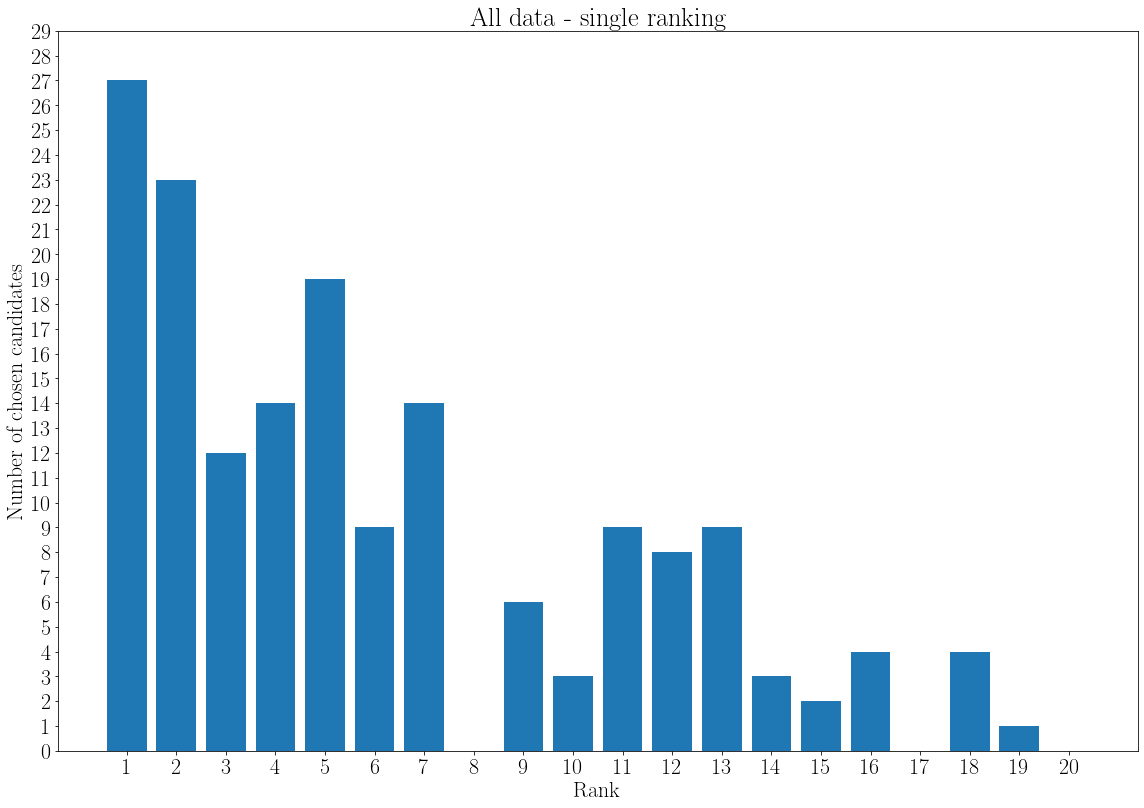

In [3]:
pairs = get_ranking_action_pairs_by_ranking_type(alldicts,[0,1,2,3])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs)
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,30, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('All data - single ranking')
plt.show()

[48. 34. 10.  6.  3.  5.  6.  6.  5.  4.]


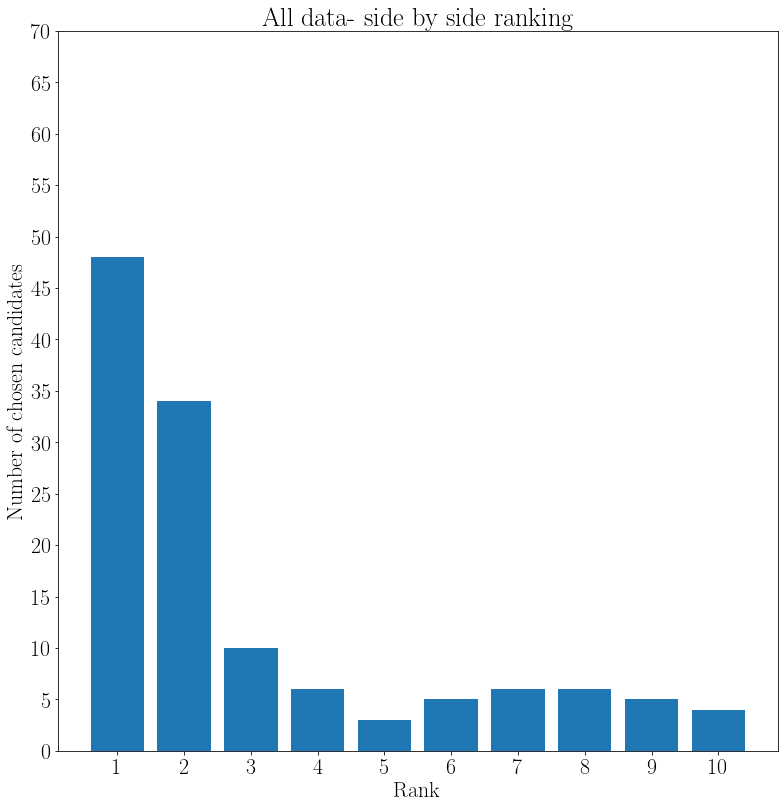

In [4]:
pairs = get_ranking_action_pairs_by_ranking_type(alldicts,[4,5,6,7])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,11)
students = get_chosen_rank_distribution(pairs)
students = students[0:10]
print(students)
ax.bar(langs,students)
plt.xticks(np.arange(1, 11, step=1))
plt.yticks(np.arange(0,75, step=5))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('All data- side by side ranking')
plt.show()

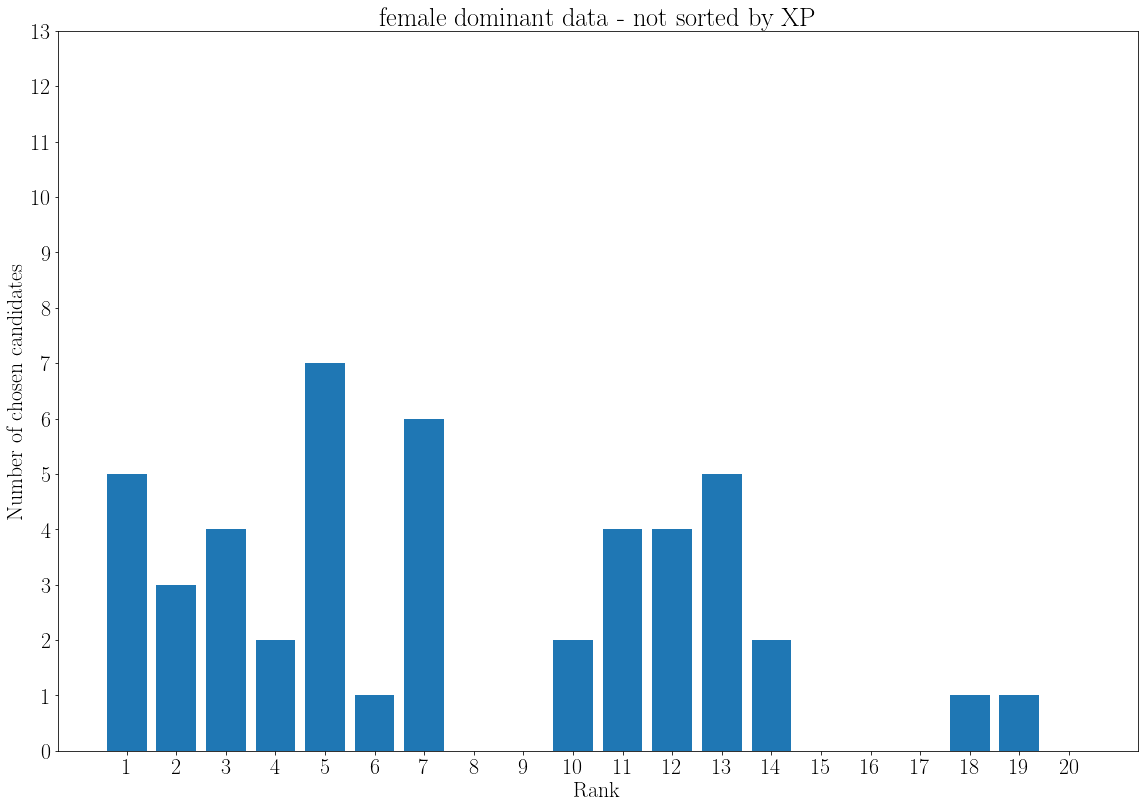

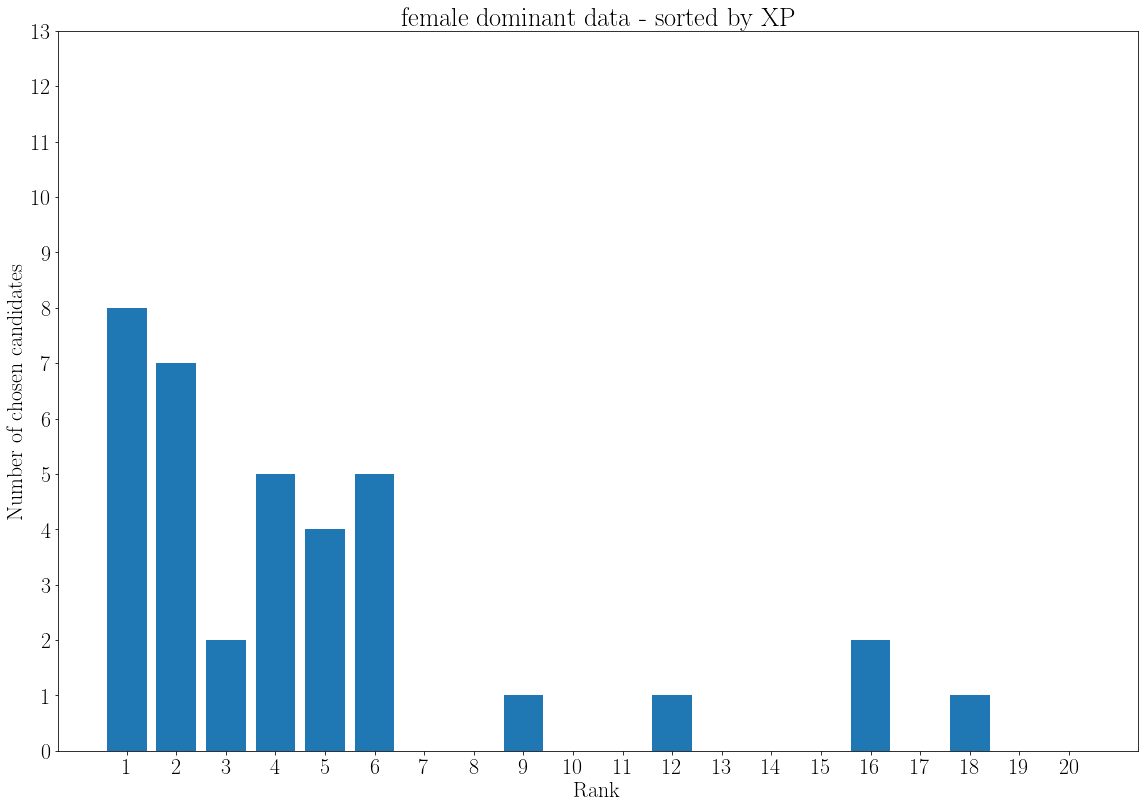

In [5]:
pairs_female_dom_not_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [0])
pairs_female_dom_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [2])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs_female_dom_not_sorted)
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('female dominant data - not sorted by XP')
plt.show()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs_female_dom_sorted)
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('female dominant data - sorted by XP')
plt.show()

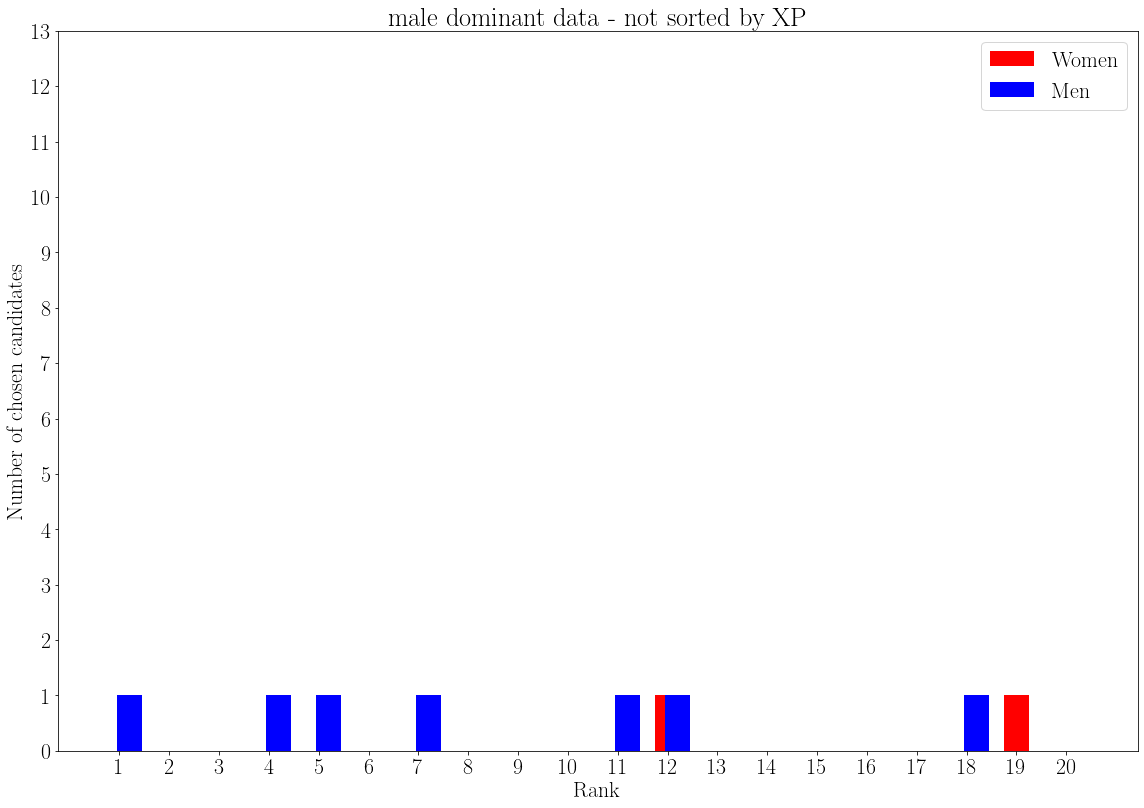

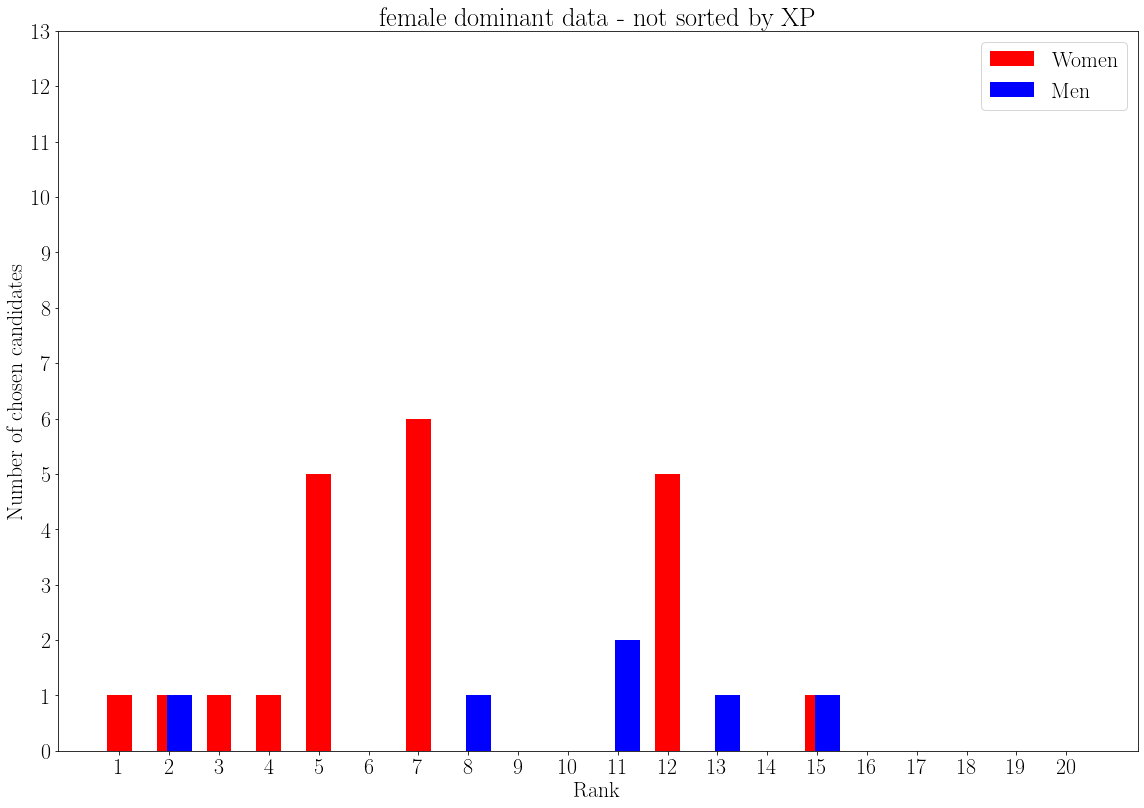

In [29]:
data = []
pairs_male_dom_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [3])
pairs_female_dom_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [2])
pairs_female_dom_not_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [0])
pairs_male_dom_not_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [1])
data.append(get_gender_chosen_rank_distribution(pairs_male_dom_not_sorted, "f"))
data.append(get_gender_chosen_rank_distribution(pairs_male_dom_not_sorted, "m"))
X = np.arange(start=1, stop=21, step=1)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.5)
ax.bar(X + 0.2, data[1], color = 'b', width = 0.5)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
ax.legend(labels=['Women', 'Men'])
plt.title('male dominant data - not sorted by XP')
plt.show()

data = []
data.append(get_gender_chosen_rank_distribution(pairs_female_dom_not_sorted, "f"))
data.append(get_gender_chosen_rank_distribution(pairs_female_dom_not_sorted, "m"))
X = np.arange(start=1, stop=21, step=1)
fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.5)
ax.bar(X + 0.2, data[1], color = 'b', width = 0.5)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
ax.legend(labels=['Women', 'Men'])
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('female dominant data - not sorted by XP')
plt.show()

47.0


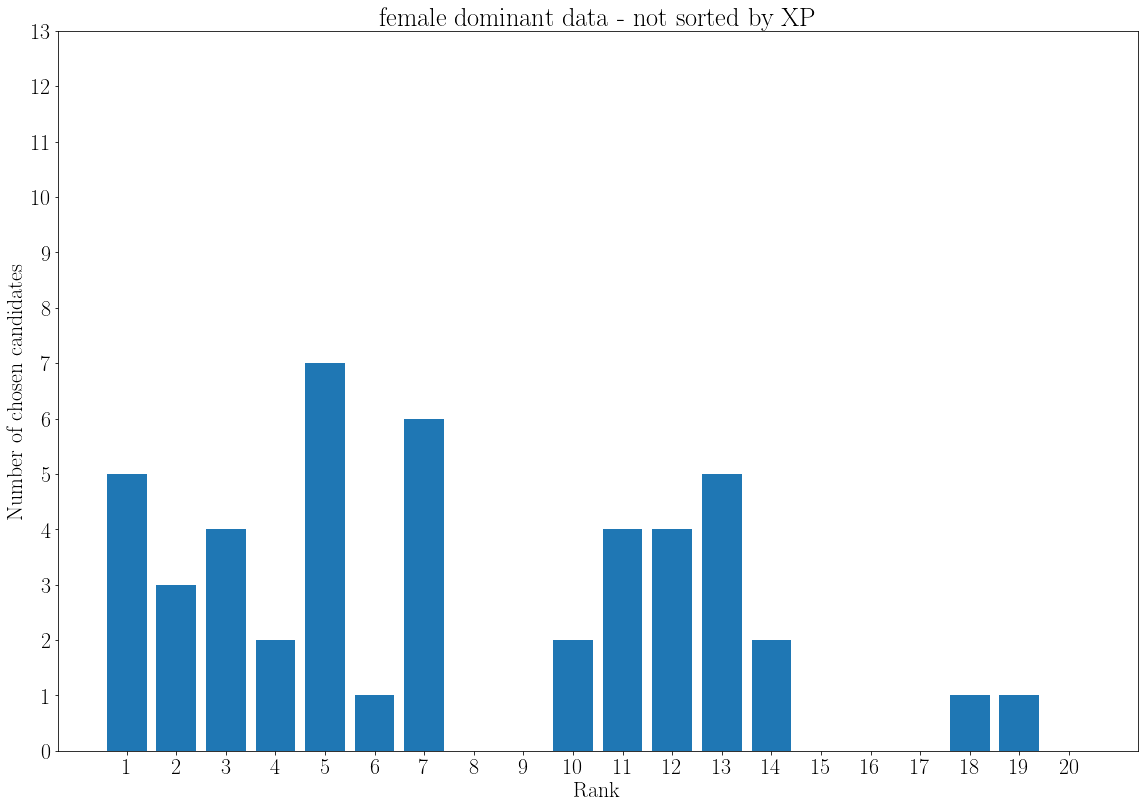

47.0


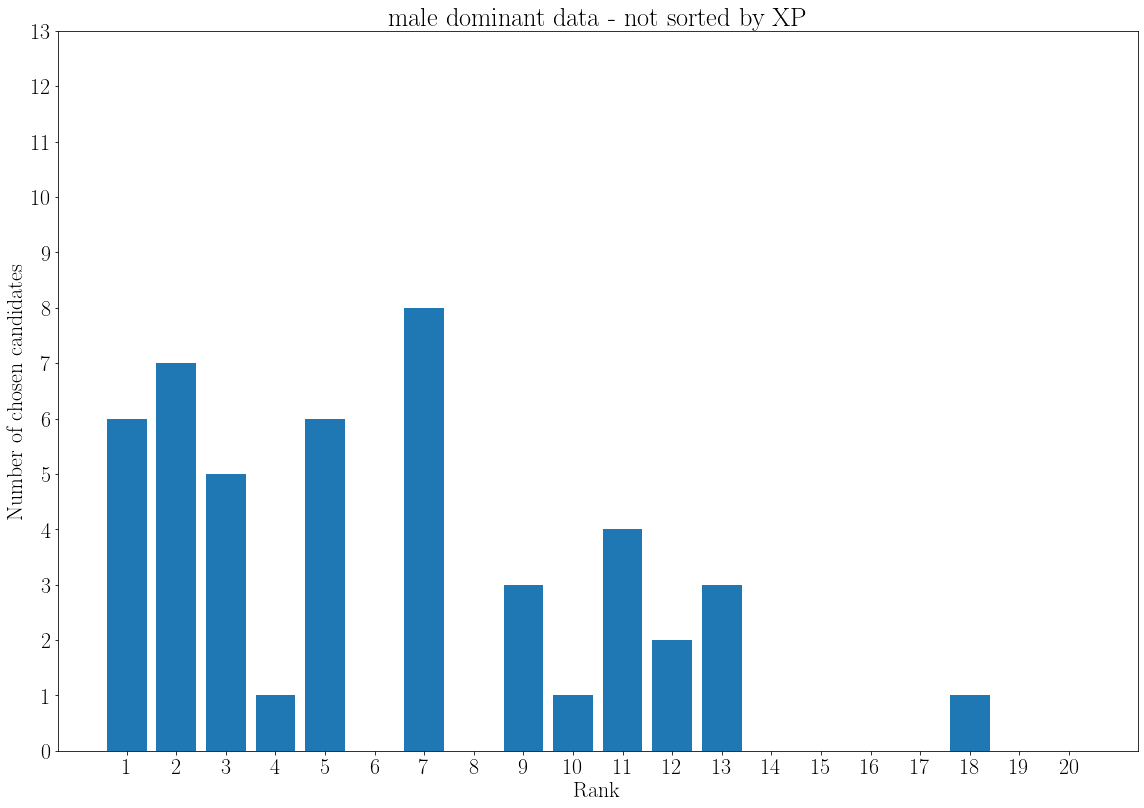

In [6]:
pairs_female_dom_not_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [0])
pairs_male_dom_not_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [1])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs_female_dom_not_sorted)
print(np.sum(students))
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('female dominant data - not sorted by XP')
plt.show()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs_male_dom_not_sorted)
print(np.sum(students))
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('male dominant data - not sorted by XP')
plt.show()

36.0


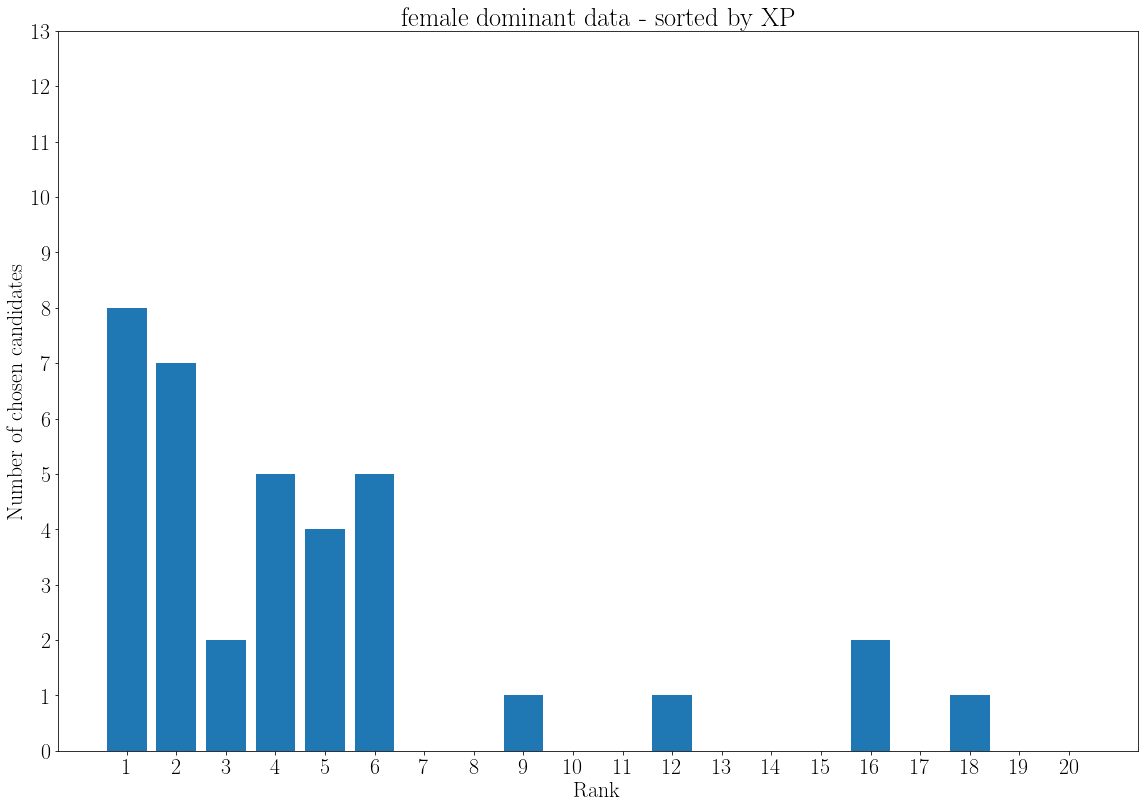

[8. 6. 1. 6. 2. 3. 0. 0. 2. 0. 1. 1. 1. 1. 2. 2. 0. 1. 0. 0.]
37.0


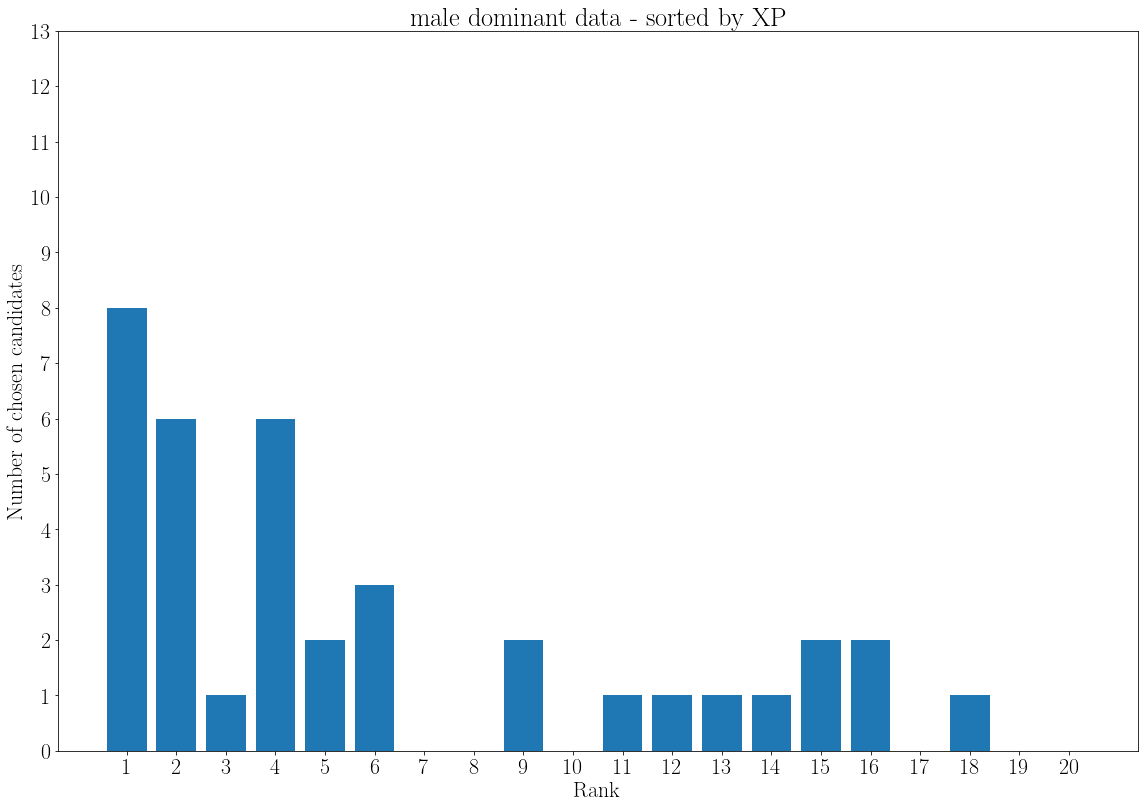

In [9]:
pairs_female_dom_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [2])
pairs_male_dom_sorted = get_ranking_action_pairs_by_ranking_type(alldicts, [3])

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs_female_dom_sorted)
print(np.sum(students))
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('female dominant data - sorted by XP')
plt.show()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_axes([0,0,1,1])
langs = range(1,21)
students = get_chosen_rank_distribution(pairs_male_dom_sorted)
print(students)
print(np.sum(students))
ax.bar(langs,students)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,14, step=1))
plt.xlabel('Rank')
plt.ylabel('Number of chosen candidates')
plt.title('male dominant data - sorted by XP')
plt.show()

In [1]:
num_males = 0
num_females = 0
for item in alldicts:
    rt = item["ranking"][0]["itemID"]
    if rt == 1 or rt == 3:
        choices = get_number_of_male_and_female_candidates_of_experiement(get_choices_of_respondent(item))
        for choice in choices:
            num_males+= choice[0]
            num_females+=choice[1]
print("men more exp")
print("males " + str(num_males))
print("females " + str(num_females))
print("\n")
num_males = 0
num_females = 0
for item in alldicts:
    rt = item["ranking"][0]["itemID"]
    if rt == 0 or rt == 2:
        choices = get_number_of_male_and_female_candidates_of_experiement(get_choices_of_respondent(item))
        for choice in choices:
            num_males+= choice[0]
            num_females+=choice[1]
print("women more exp:")
print("males " + str(num_males))
print("females " + str(num_females))

NameError: name 'alldicts' is not defined

83
79


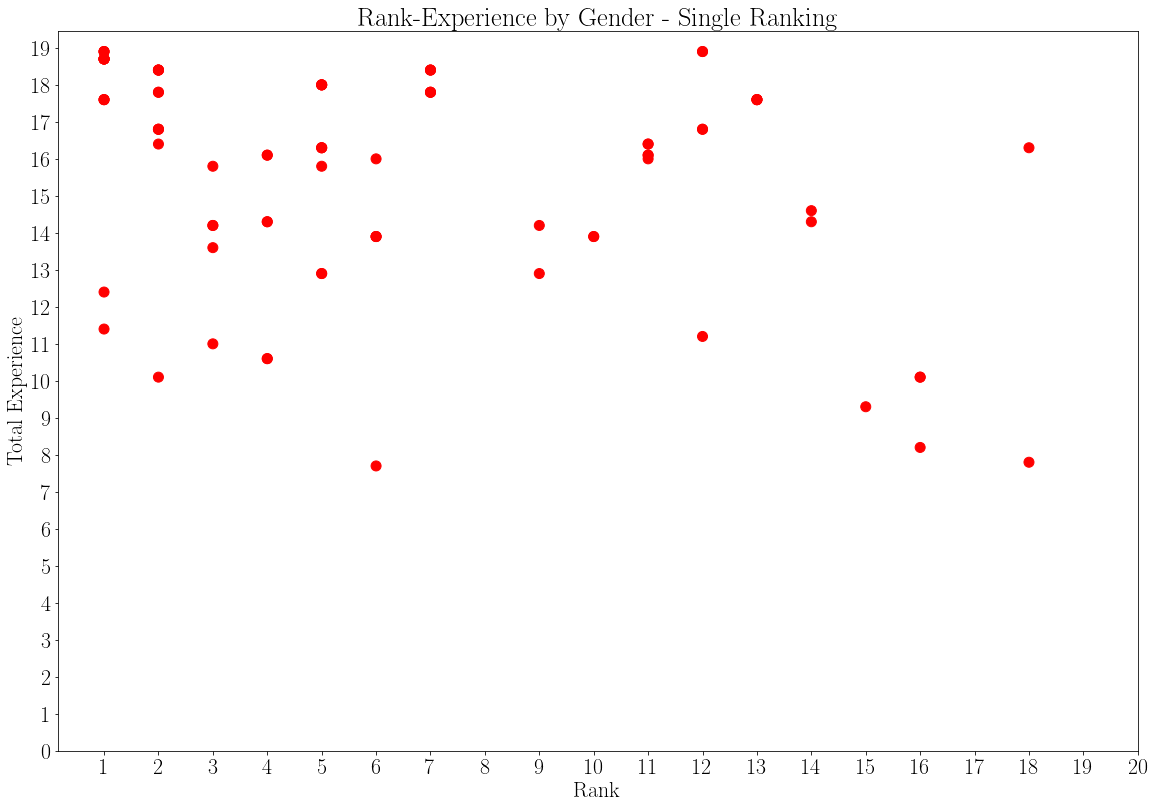

83
79


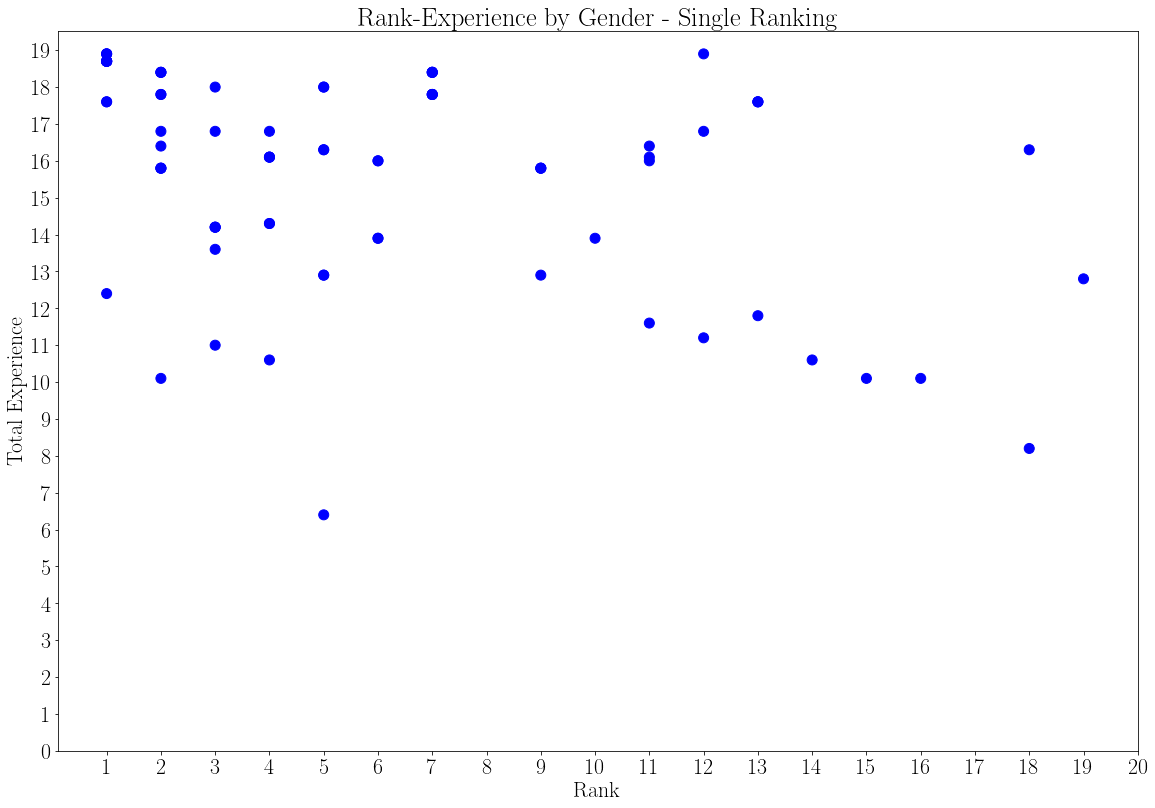

In [7]:
pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts,ranking_types = [0,1,2,3])

female_total_experience, female_ranks, male_total_experience, male_ranks = split_xp_rank_gender_tuples_in_4_lists(pairs)
s_f = [100] * len(female_total_experience)
s_m = [100] * len(male_total_experience)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
ax.scatter(female_ranks, female_total_experience, color='r', s=s_f)
#ax.scatter(male_ranks, male_total_experience, color='b', s=s_m)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,20, step=1))
print(len(female_total_experience))
print(len(male_total_experience))
ax.set_xlabel('Rank')
ax.set_ylabel('Total Experience')
ax.set_title('Rank-Experience by Gender - Single Ranking')
plt.show()


pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts,ranking_types = [0,1,2,3])

female_total_experience, female_ranks, male_total_experience, male_ranks = split_xp_rank_gender_tuples_in_4_lists(pairs)
s_f = [100] * len(female_total_experience)
s_m = [100] * len(male_total_experience)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
#ax.scatter(female_ranks, female_total_experience, color='r', s=s_f)
ax.scatter(male_ranks, male_total_experience, color='b', s=s_m)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,20, step=1))
print(len(female_total_experience))
print(len(male_total_experience))
ax.set_xlabel('Rank')
ax.set_ylabel('Total Experience')
ax.set_title('Rank-Experience by Gender - Single Ranking')
plt.show()


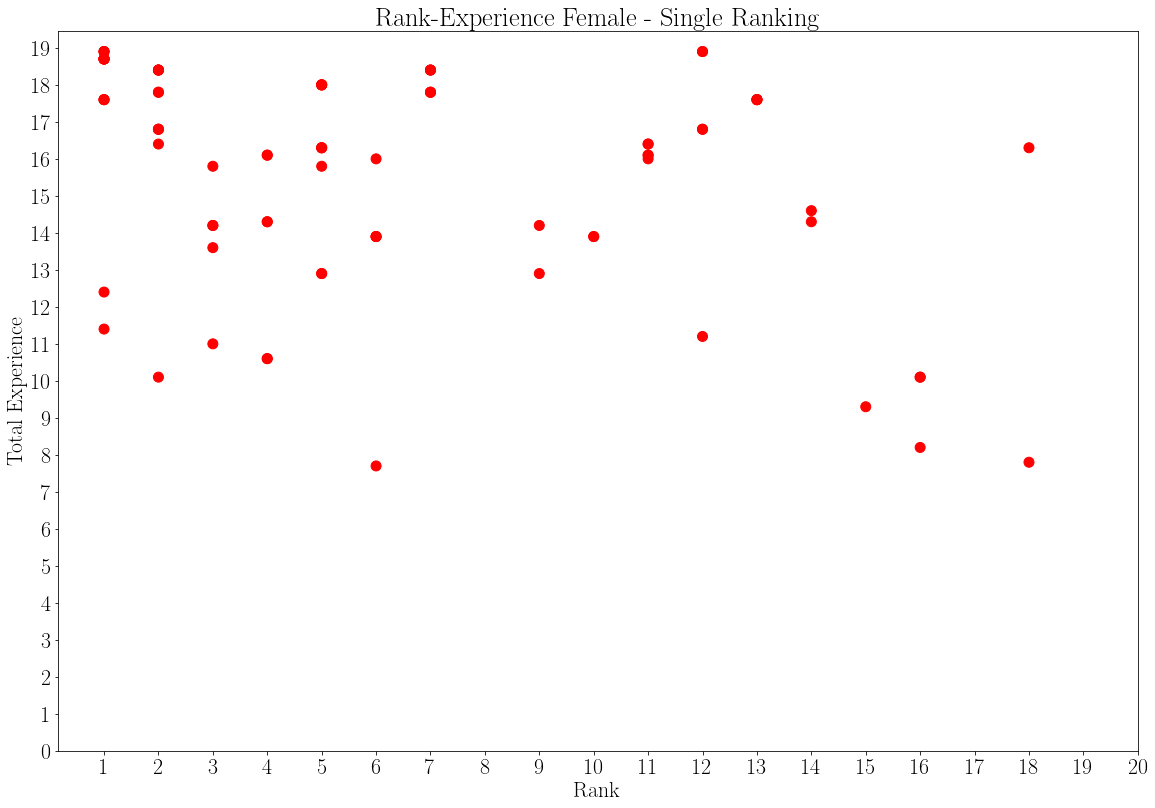

83
79


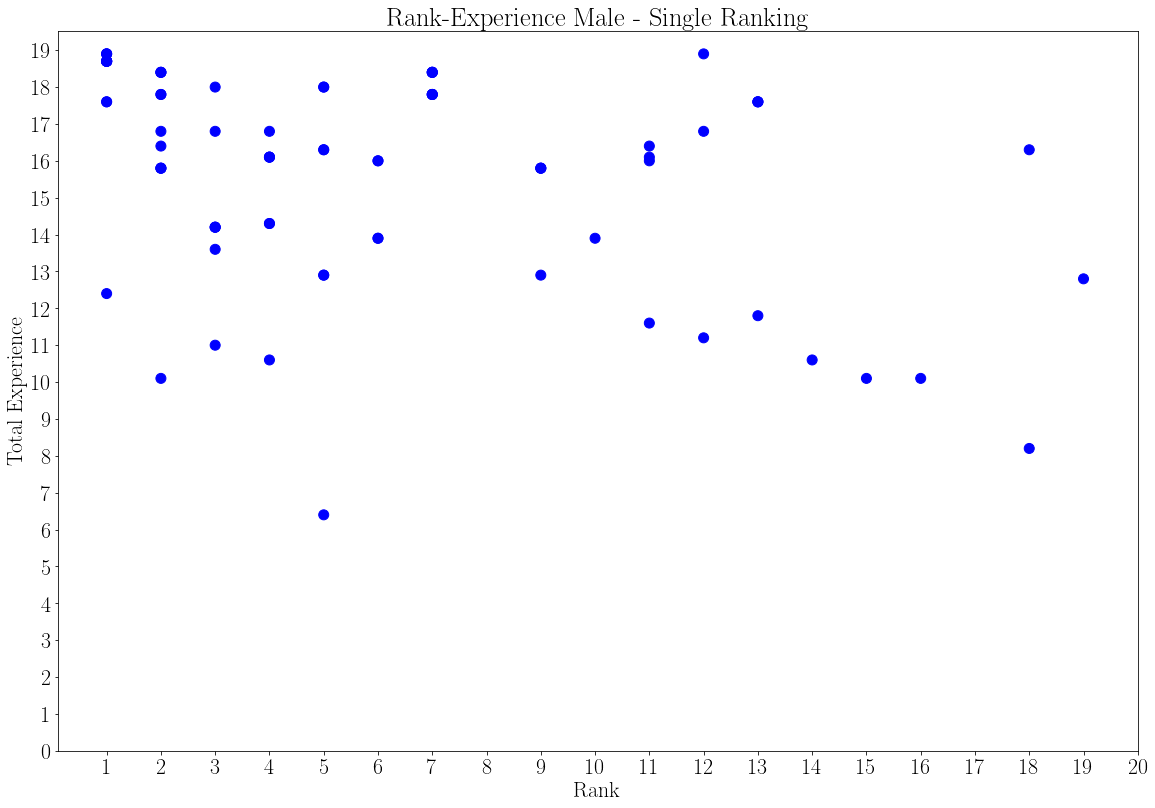

In [8]:
pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts,ranking_types = [0,1,2,3])

female_total_experience, female_ranks, male_total_experience, male_ranks = split_xp_rank_gender_tuples_in_4_lists(pairs)
s_f = [100] * len(female_total_experience)
s_m = [100] * len(male_total_experience)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
ax.scatter(female_ranks, female_total_experience, color='r', s=s_f)
#ax.scatter(male_ranks, male_total_experience, color='b', s=s_m)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,20, step=1))
ax.set_xlabel('Rank')
ax.set_ylabel('Total Experience')
ax.set_title('Rank-Experience Female - Single Ranking')
plt.show()

female_total_experience, female_ranks, male_total_experience, male_ranks = split_xp_rank_gender_tuples_in_4_lists(pairs)
s_f = [100] * len(female_total_experience)
s_m = [100] * len(male_total_experience)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
print(len(female_total_experience))
print(len(male_total_experience))
#ax.scatter(female_ranks, female_total_experience, color='r', s=s_f)
ax.scatter(male_ranks, male_total_experience, color='b', s=s_m)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,20, step=1))
ax.set_xlabel('Rank')
ax.set_ylabel('Total Experience')
ax.set_title('Rank-Experience Male - Single Ranking')
plt.show()

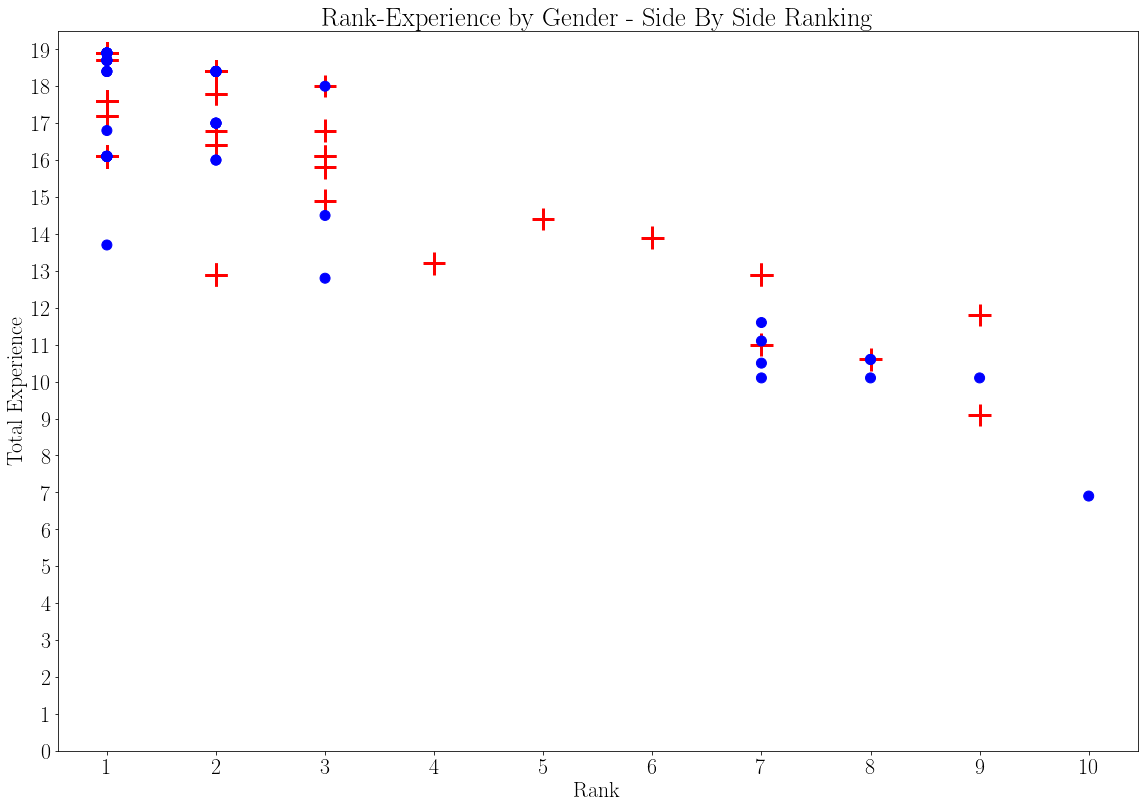

In [12]:
path_to_jsonfiles = "./jsonFiles_valid"
alldicts = []
for file in os.listdir(path_to_jsonfiles):
    full_filename = "%s/%s" % (path_to_jsonfiles, file)
    with open(full_filename,'r') as fi:
        dict = json.load(fi)
        alldicts.append(dict)
pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts, ranking_types=[4,5,6,7])
female_total_experience, female_ranks, male_total_experience, male_ranks = split_xp_rank_gender_tuples_in_4_lists(pairs)
s_f = [500] * len(female_total_experience)
s_m = [100] * len(male_total_experience)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
ax.scatter(female_ranks, female_total_experience, color='r', s=s_f, marker='+')
ax.scatter(male_ranks, male_total_experience, color='b', s=s_m)
plt.xticks(np.arange(1, 11, step=1))
plt.yticks(np.arange(0,20, step=1))
ax.set_xlabel('Rank')
ax.set_ylabel('Total Experience')
ax.set_title('Rank-Experience by Gender - Side By Side Ranking')
ax.legend()
plt.show()

In [35]:
pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts,ranking_types = [0,1,2,3])

female_furniture_xp, female_home_xp, female_rank, male_furniture_xp, male_home_xp, male_rank = gender_xp_tuples_for_tasks(pairs, tasks =[1])


15
12


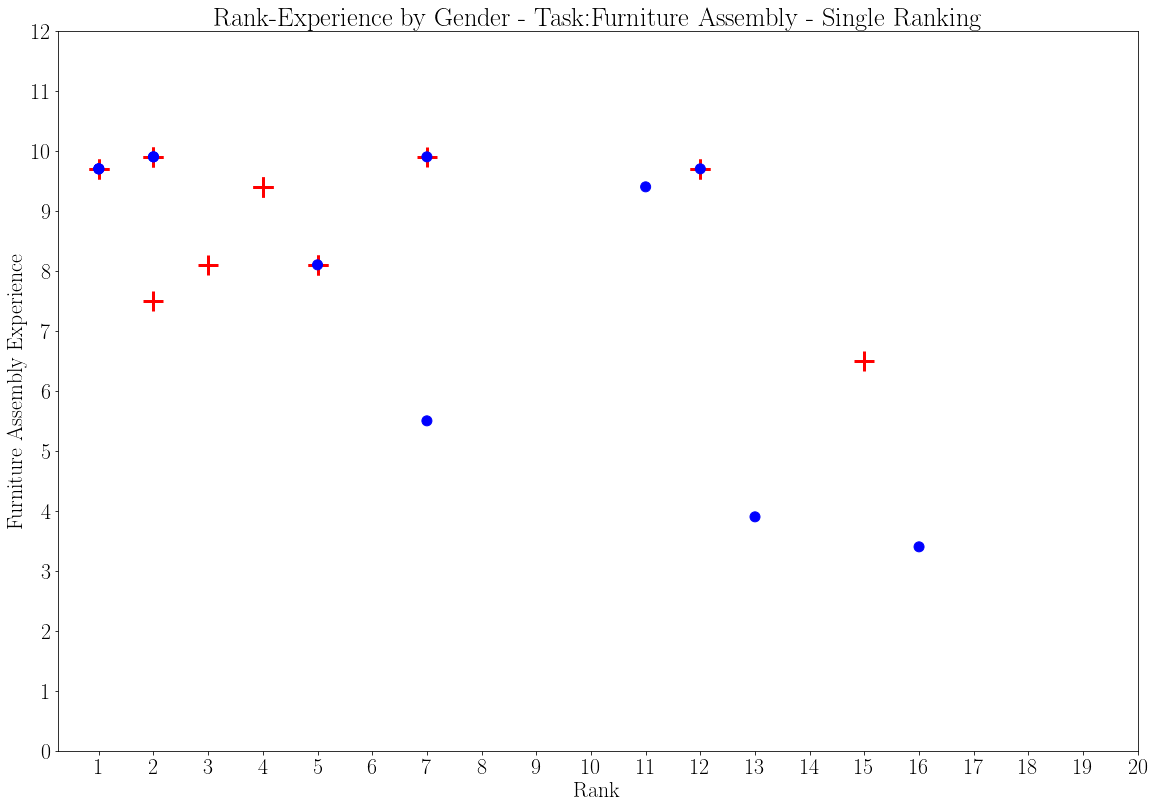

In [36]:
s_f = [400] * len(female_furniture_xp)
s_m = [100] * len(male_furniture_xp)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
print(len(female_rank))
print(len(male_rank))
ax.scatter(female_rank, female_furniture_xp, color='r', s=s_f, marker='+')
ax.scatter(male_rank, male_furniture_xp, color='b', s=s_m)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,13, step=1))
ax.set_xlabel('Rank')
ax.set_ylabel('Furniture Assembly Experience')
ax.set_title('Rank-Experience by Gender - Task:Furniture Assembly - Single Ranking')
plt.show()

15
12


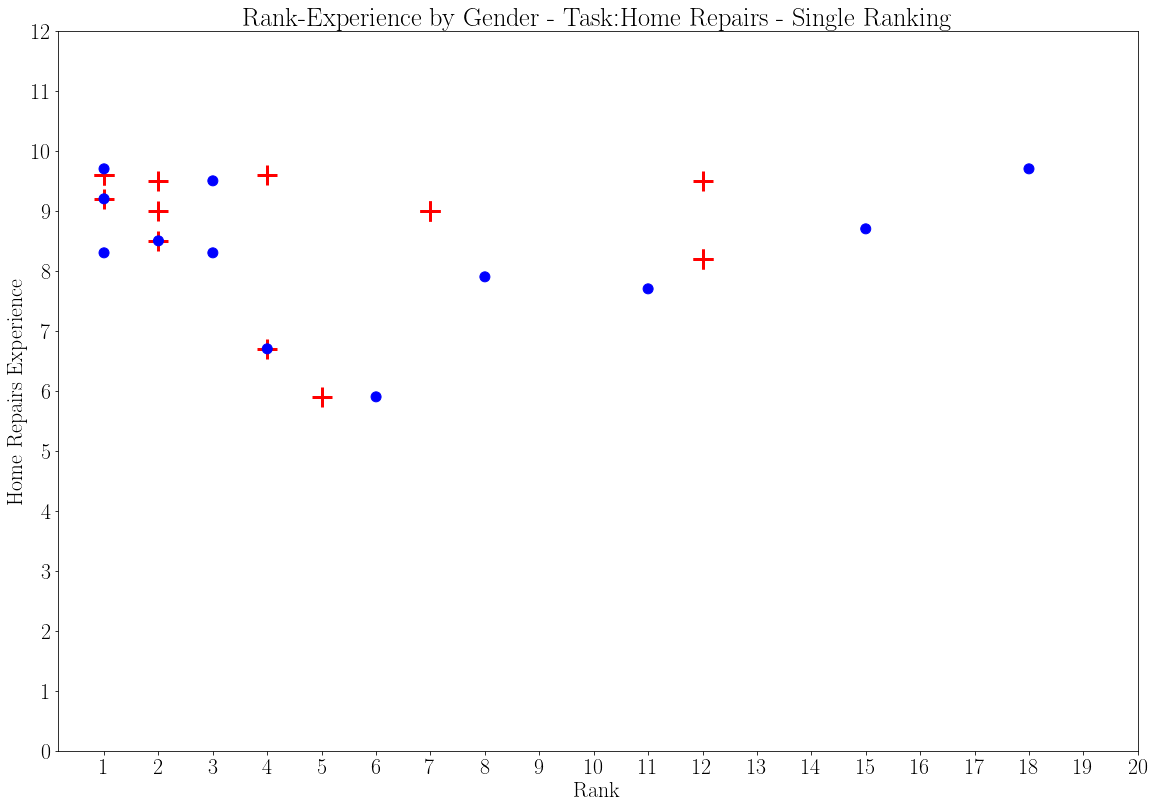

In [37]:
pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts,ranking_types = [0,1,2,3])

female_furniture_xp, female_home_xp, female_rank, male_furniture_xp, male_home_xp, male_rank = gender_xp_tuples_for_tasks(pairs, tasks =[2])

s_f = [400] * len(female_home_xp)
s_m = [100] * len(male_home_xp)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
print(len(female_rank))
print(len(male_rank))
ax.scatter(female_rank, female_home_xp, color='r', s=s_f, marker='+')
ax.scatter(male_rank, male_home_xp, color='b', s=s_m, marker='o')
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,13, step=1))
ax.set_xlabel('Rank')
ax.set_ylabel('Home Repairs Experience')
ax.set_title('Rank-Experience by Gender - Task:Home Repairs - Single Ranking')
plt.show()

19
8


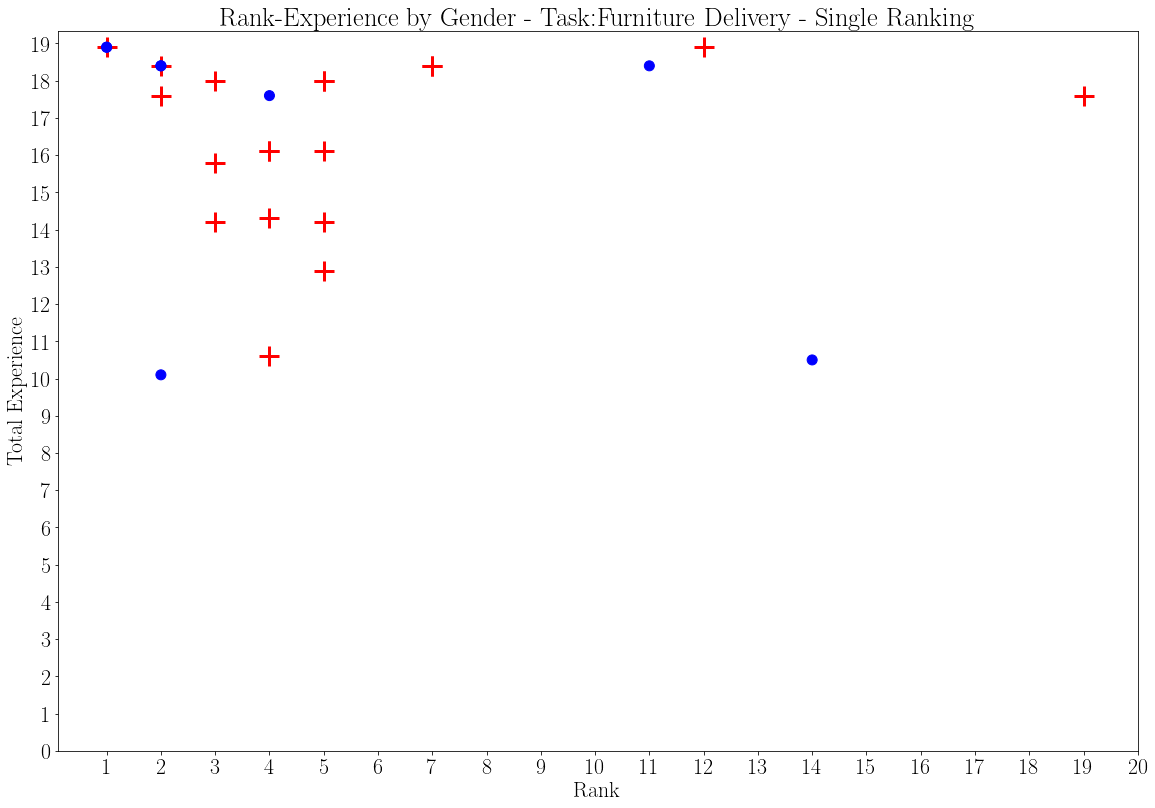

In [38]:
pairs = create_xp_rank_gender_ranking_type_plot_data(alldicts,ranking_types = [0,1,2,3])

female_furniture_xp, female_home_xp, female_rank, male_furniture_xp, male_home_xp, male_rank = gender_xp_tuples_for_tasks(pairs, tasks =[3])

male_total_xp = [0] * len(male_home_xp)
female_total_xp = [0] * len(female_home_xp)
for i in range(0,len(male_home_xp)):
    male_total_xp[i] += male_home_xp[i]
for i in range(0,len(male_furniture_xp)):
    male_total_xp[i] += male_furniture_xp[i]
for i in range(0,len(female_home_xp)):
    female_total_xp[i] += female_home_xp[i]
for i in range(0,len(female_furniture_xp)):
    female_total_xp[i] += female_furniture_xp[i]
s_f = [400] * len(female_home_xp)
print(len(female_rank))
print(len(male_rank))
s_m = [100] * len(male_home_xp)
fig = plt.figure(figsize=(15, 10))
ax=fig.add_axes([0,0,1,1])
ax.scatter(female_rank, female_total_xp, color='r', s=s_f, marker='+')
ax.scatter(male_rank, male_total_xp, color='b', s=s_m)
plt.xticks(np.arange(1, 21, step=1))
plt.yticks(np.arange(0,20, step=1))
ax.set_xlabel('Rank')
ax.set_ylabel('Total Experience')
ax.set_title('Rank-Experience by Gender - Task:Furniture Delivery - Single Ranking')
plt.show()